In [1]:
import os
import sys
import pickle
import time

PROJECT_ROOT = os.path.abspath('..')
sys.path.append(PROJECT_ROOT)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import scipy
from scipy import stats
from tqdm import tqdm

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants, viz, pkeys
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection.predicted_dataset import PredictedDataset
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import det_utils
from figs_thesis import fig_utils

viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

RESULTS_PATH = os.path.join(PROJECT_ROOT, 'results')
LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

# Load NSRR dataset and pre-computed predicted dataset

In [ ]:
nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True)

In [ ]:
parts_to_load = [0]  # 0 to 11

pred_objects = []
for part in parts_to_load:
    filepath = os.path.join(
        RESULTS_PATH, 'predictions_nsrr_ss',
        'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
        'v2_time',
        'prediction_part%d.pkl' % part
    )
    with open(filepath, 'rb') as handle:
        pred_object = pickle.load(handle)
    pred_object.set_parent_dataset(nsrr)
    pred_objects.append(pred_object)

<h1> Dataset de parámetros</h1>

Parámetros no definidos son NaN.

In [2]:
# Filenames of dataset checkpoints
byevent_ckpt_path = os.path.join(
    RESULTS_PATH, 'predictions_nsrr_ss',
    'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
    'v2_time',
    'table_byevent.csv'
)
bysubject_ckpt_path = os.path.join(
    RESULTS_PATH, 'predictions_nsrr_ss',
    'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
    'v2_time',
    'table_bysubject.csv'
)

In [3]:
params_load_checkpoint = True

# ############################

if params_load_checkpoint:
    print("Loading from checkpoint")
    table_byevent = pd.read_csv(byevent_ckpt_path)
    table_bysubject = pd.read_csv(bysubject_ckpt_path)

else:
    # Perform computation and save checkpoint
    table_byevent = {
        'subject_id': [],
        'mark_id': [],
        'duration': [], 
        'amplitude': [],
        'frequency': [],
    }
    table_bysubject = {
        'subject_id': [],
        'age': [], 
        'female': [],
        'n2_minutes': [],
        'n2_abs_sigma_power': [],
        'n2_rel_sigma_power': [],
        'n2_pl_exponent': [],
        'density': [],
        'duration': [], 
        'amplitude': [],
        'frequency': [],
    }

    min_n2_minutes = 60
    verbose_min_minutes = False

    start_time = time.time()
    print("Generating table of parameters")
    for part_id, predictions in enumerate(pred_objects):
        print("Processing Part %d / %d" % (part_id + 1, len(pred_objects)))
        for subject_id in tqdm(predictions.all_ids):
            n2_pages = predictions.data[subject_id]['n2_pages']
            n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
            if n2_minutes < min_n2_minutes:
                if verbose_min_minutes:
                    print("Skipped by N2 minutes: Subject %s with %d N2 minutes" % (subject_id, n2_minutes))
                continue

            # Now compute parameters
            subject_data = nsrr.read_subject_data(subject_id, exclusion_of_pages=False)
            signal = subject_data['signal']
            age = float(subject_data['age'].item())
            female = int(subject_data['sex'].item() == 'f')

            # By-subject spectral parameters
            signal_n2 = signal.reshape(-1, nsrr.fs * nsrr.original_page_duration)[n2_pages].flatten()
            freq, power = utils.power_spectrum_by_sliding_window(signal_n2, nsrr.fs, window_duration=5)
            # a) Absolute sigma power 
            n2_abs_sigma_power = power[(freq >= 11) & (freq <= 16)].mean()
            # b) Relative sigma power (as in Lacourse)
            n2_broad_power = power[(freq >= 4.5) & (freq <= 30)].mean()
            n2_rel_sigma_power = n2_abs_sigma_power / n2_broad_power
            # c) Power law exponent 2-30 Hz without sigma band (same as exclusion process)
            locs_to_use = np.where(((freq >= 2) & (freq < 10)) | ((freq > 17) & (freq <= 30)))[0]
            log_x = np.log(freq[locs_to_use])
            log_y = np.log(power[locs_to_use])
            n2_pl_exponent, _, _, _, _ = scipy.stats.linregress(log_x, log_y)

            # Spindle parameters
            marks = predictions.get_subject_stamps(subject_id, pages_subset='n2')
            n_marks = marks.shape[0]
            density = n_marks / n2_minutes  # epm
            if n_marks == 0:
                # Dummy entries
                be_subject_id = [subject_id]
                be_mark_id = [np.nan]
                be_duration = [np.nan]
                be_amplitude = [np.nan]
                be_frequency = [np.nan]
            else:
                be_subject_id = [subject_id] * n_marks
                be_mark_id = np.arange(n_marks)

                be_duration = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs

                filt_signal = param_filtering_fn(signal, nsrr.fs, constants.SPINDLE)
                signal_events = [filt_signal[e[0]:(e[1]+1)] for e in marks]

                be_amplitude = np.array([
                    param_amplitude_fn(s, nsrr.fs, constants.SPINDLE) for s in signal_events
                ])

                be_frequency = np.array([
                    param_frequency_fn(s, nsrr.fs) for s in signal_events
                ])

            # By-subject averages
            bs_duration = np.mean(be_duration)
            bs_amplitude = np.mean(be_amplitude)
            bs_frequency = np.mean(be_frequency)

            # Save parameters
            table_byevent['subject_id'].append(be_subject_id)
            table_byevent['mark_id'].append(be_mark_id)
            table_byevent['duration'].append(be_duration)
            table_byevent['amplitude'].append(be_amplitude)
            table_byevent['frequency'].append(be_frequency)

            table_bysubject['subject_id'].append(subject_id)
            table_bysubject['age'].append(age)
            table_bysubject['female'].append(female)
            table_bysubject['n2_minutes'].append(n2_minutes)
            table_bysubject['n2_abs_sigma_power'].append(n2_abs_sigma_power)
            table_bysubject['n2_rel_sigma_power'].append(n2_rel_sigma_power)
            table_bysubject['n2_pl_exponent'].append(n2_pl_exponent)
            table_bysubject['density'].append(density)
            table_bysubject['duration'].append(bs_duration)
            table_bysubject['amplitude'].append(bs_amplitude)
            table_bysubject['frequency'].append(bs_frequency) 
    end_time = time.time()
    et_time = (end_time - start_time) / 60  # minutes
    print("Elapsed time: %1.4f minutes" % et_time)
    
    for key in table_byevent:
        table_byevent[key] = np.concatenate(table_byevent[key])
    table_byevent = pd.DataFrame.from_dict(table_byevent)
    table_bysubject = pd.DataFrame.from_dict(table_bysubject)
   
    # Save checkpoint
    print("Saving checkpoint")
    table_byevent.to_csv(byevent_ckpt_path, index=False)
    table_bysubject.to_csv(bysubject_ckpt_path, index=False)
    print("Done.")

Loading from checkpoint


In [4]:
print(table_byevent.shape)
table_byevent.head()

(2319290, 5)


,subject_id,mark_id,duration,amplitude,frequency
0,ccshs-trec-1800034,0.0,0.44,24.371809,13.9
1,ccshs-trec-1800034,1.0,0.72,28.900696,14.8
2,ccshs-trec-1800034,2.0,1.48,23.536839,15.4
3,ccshs-trec-1800034,3.0,0.60,26.453024,15.2
4,ccshs-trec-1800034,4.0,0.64,68.478527,14.3


In [5]:
print(table_bysubject.shape)
table_bysubject.head()

(11224, 11)


,subject_id,age,female,n2_minutes,n2_abs_sigma_power,n2_rel_sigma_power,n2_pl_exponent,density,duration,amplitude,frequency
0,ccshs-trec-1800034,17.40,1,163.0,0.386454,1.859941,-1.279945,4.969325,1.116099,46.538635,13.508025
1,ccshs-trec-1800038,17.40,1,217.5,0.308670,1.510728,-1.136783,4.422989,1.102703,39.584287,12.762682
2,ccshs-trec-1800065,17.68,1,222.5,0.226842,1.522630,-1.228495,3.038202,0.955740,31.335450,12.873225
3,ccshs-trec-1800074,17.86,1,214.0,0.284249,1.389635,-1.336513,2.901869,0.874654,40.135913,13.146055
4,ccshs-trec-1800078,17.77,0,238.0,0.253408,1.328701,-1.223523,2.630252,0.834952,32.414402,13.200639


# Final NSRR composition statistics

Measure number of subjects and N2 hours of each subdataset (consider also zero marks subjects because this table should be independent from the detector). The idea is to say: the dataset was reduced from X subjects/hours to Y subjects/hours. On this dataset, there are Z total spindle detections to analyze.

In [6]:
table_bysubject['origin'] = [s.split("-")[0] for s in table_bysubject.subject_id.values]
table_bysubject.head()

,subject_id,age,female,n2_minutes,n2_abs_sigma_power,n2_rel_sigma_power,n2_pl_exponent,density,duration,amplitude,frequency,origin
0,ccshs-trec-1800034,17.40,1,163.0,0.386454,1.859941,-1.279945,4.969325,1.116099,46.538635,13.508025,ccshs
1,ccshs-trec-1800038,17.40,1,217.5,0.308670,1.510728,-1.136783,4.422989,1.102703,39.584287,12.762682,ccshs
2,ccshs-trec-1800065,17.68,1,222.5,0.226842,1.522630,-1.228495,3.038202,0.955740,31.335450,12.873225,ccshs
3,ccshs-trec-1800074,17.86,1,214.0,0.284249,1.389635,-1.336513,2.901869,0.874654,40.135913,13.146055,ccshs
4,ccshs-trec-1800078,17.77,0,238.0,0.253408,1.328701,-1.223523,2.630252,0.834952,32.414402,13.200639,ccshs


In [7]:
origin_stats = table_bysubject[["subject_id", "origin"]].groupby(by="origin").count()
origin_stats['hours'] = table_bysubject[["n2_minutes", "origin"]].groupby(by="origin").sum() / 60  # hours
origin_stats['min_age'] = table_bysubject[["age", "origin"]].groupby(by="origin").min()
origin_stats['max_age'] = table_bysubject[["age", "origin"]].groupby(by="origin").max()
origin_stats['female'] = table_bysubject[["female", "origin"]].groupby(by="origin").mean() * 100
print(origin_stats)
print("")
print("Total:")
print("Number of subjects:", len(table_bysubject))
print("Number of hours: %1.6f" % (table_bysubject["n2_minutes"].sum() / 60))
# print(origin_stats[["subject_id", "hours"]].sum())
print("Age:", table_bysubject["age"].min(), table_bysubject["age"].max())
print("Female:", 100 * table_bysubject["female"].mean())

        subject_id         hours    min_age   max_age      female
origin                                                           
ccshs          513   1734.691667  16.140000  19.56000   49.512671
cfs            711   2271.033333   6.765229  88.53388   54.992968
chat          1053   2271.208333   4.500000  10.00000   52.706553
mros          2862  10158.808333  67.000000  90.00000    0.000000
shhs1         5648  18755.566667  39.000000  90.00000   52.283994
sof            437   1356.741667  75.000000  90.00000  100.000000

Total:
Number of subjects: 11224
Number of hours: 36548.050000
Age: 4.5 90.0
Female: 40.89451176051318


In [8]:
print("Subjects without detections:")
table_bysubject[table_bysubject['density'] <= 0]

Subjects without detections:


,subject_id,age,female,n2_minutes,n2_abs_sigma_power,n2_rel_sigma_power,n2_pl_exponent,density,duration,amplitude,frequency,origin
487,shhs1-200721,61.00000,0,87.5,0.120748,1.205779,-1.016663,0.0,NaN,NaN,NaN,shhs1
2965,cfs-visit5-801177,76.38056,0,62.0,0.226105,1.084217,-1.244129,0.0,NaN,NaN,NaN,cfs
3328,mros-visit1-aa5843,73.00000,0,81.5,0.157315,0.821180,-1.475405,0.0,NaN,NaN,NaN,mros
4022,chat-baseline-nonrandomized-300577,4.80000,1,137.0,0.115866,0.846627,-1.507882,0.0,NaN,NaN,NaN,chat
7102,mros-visit1-aa3593,68.00000,0,170.5,0.130469,1.094755,-1.068446,0.0,NaN,NaN,NaN,mros
10151,shhs1-200323,67.00000,0,142.5,0.151972,1.093194,-1.007131,0.0,NaN,NaN,NaN,shhs1


In [9]:
min_detections = 10

event_counts = np.round(table_bysubject["n2_minutes"] * table_bysubject["density"])
subjects_with_few_detections = np.sum(event_counts < min_detections)
print("Subjects with less than %d detections: %d (%1.4f%%)" % (
    min_detections, subjects_with_few_detections, 100 * subjects_with_few_detections / len(table_bysubject)))

Subjects with less than 10 detections: 338 (3.0114%)


# Gráficos por evento (sin agrupar por demografía)

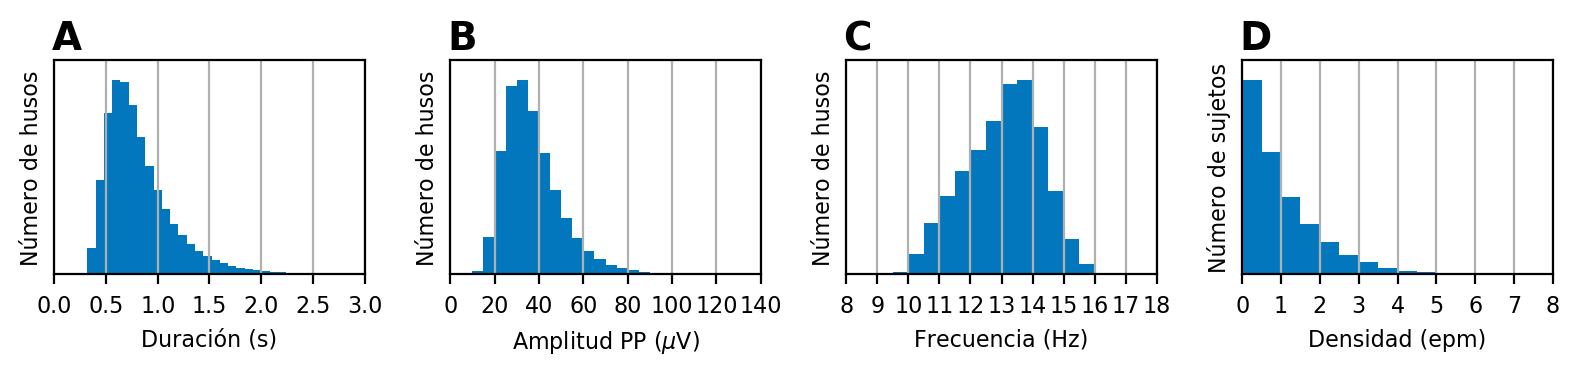

In [12]:
save_figure = True


table_byevent_valid = table_byevent.dropna()

fig, axes = plt.subplots(1, 4, figsize=(8, 2), dpi=200)

show_average = False

factor_to_lim = 1.35 if show_average else 1.1

ax = axes[0]
n, _, _ = ax.hist(table_byevent_valid.duration.values, bins=np.arange(0.0, 3.0 + 0.001, 0.08), color=viz.PALETTE['blue'])
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Duración (s)", fontsize=8)
mean_value = np.mean(table_byevent_valid.duration.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.2f s" % mean_value)
ax.set_xticks(np.arange(0, 3 + 0.001, 0.5))
ax.set_xlim([0, 3])
ax.set_ylabel("Número de husos", fontsize=8)

ax = axes[1]
n, _, _ = ax.hist(table_byevent_valid.amplitude.values, bins=np.arange(0, 135 + 0.001, 5), color=viz.PALETTE['blue'])
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Amplitud PP ($\mu$V)", fontsize=8)
mean_value = np.mean(table_byevent_valid.amplitude.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f $\mu$V" % mean_value)
ax.set_xticks(np.arange(0, 140 + 0.001, 20))
ax.set_xlim([0, 140])
ax.set_ylabel("Número de husos", fontsize=8)

ax = axes[2]
n, _, _ = ax.hist(table_byevent_valid.frequency.values, bins=np.arange(8.5, 17.5 + 0.001, 0.5), color=viz.PALETTE['blue'])
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Frecuencia (Hz)", fontsize=8)
mean_value = np.mean(table_byevent_valid.frequency.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f Hz" % mean_value)
ax.set_xticks(np.arange(8, 18 + 0.001, 1))
ax.set_xlim([8, 18])
ax.set_ylabel("Número de husos", fontsize=8)

# oscilaciones
#ax = axes[3]
#oscils = table_byevent_valid.frequency.values * table_byevent_valid.duration.values
#n, _, _ = ax.hist(oscils, color=viz.PALETTE['blue'], bins=np.arange(0, 50 + 0.001, 2.5))
#max_count = np.max(n)
#ax.set_ylim([0, factor_to_lim * max_count])
#ax.set_xlabel("Oscilaciones", fontsize=8)
#mean_value = np.mean(oscils)
#ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f" % mean_value)
#ax.set_xticks(np.arange(0, 50 + 0.001, 5))
#ax.set_xlim([0, 50])

# Densidad 
ax = axes[3]
n, _, _ = ax.hist(table_bysubject.density.values, color=viz.PALETTE['blue'], bins=np.arange(0, 8 + 0.001, 0.5))
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Densidad (epm)", fontsize=8)
mean_value = np.mean(table_bysubject.density.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f epm" % mean_value)
ax.set_xticks(np.arange(0, 8 + 0.001, 1))
ax.set_xlim([0, 8])
ax.set_ylabel("Número de sujetos", fontsize=8)


for i_ax, ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=8)
    ax.set_yticks([])
    ax.grid()
    if show_average:
        ax.legend(loc="upper right", fontsize=8, frameon=True)
    ax.text(
        x=-0.01, y=1.05, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
    
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_hist"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)

plt.show()

# Gráficos de densidad vs potencia en banda sigma

There are 835 subjects (7.4 %) with density less than 0.10 epm


/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


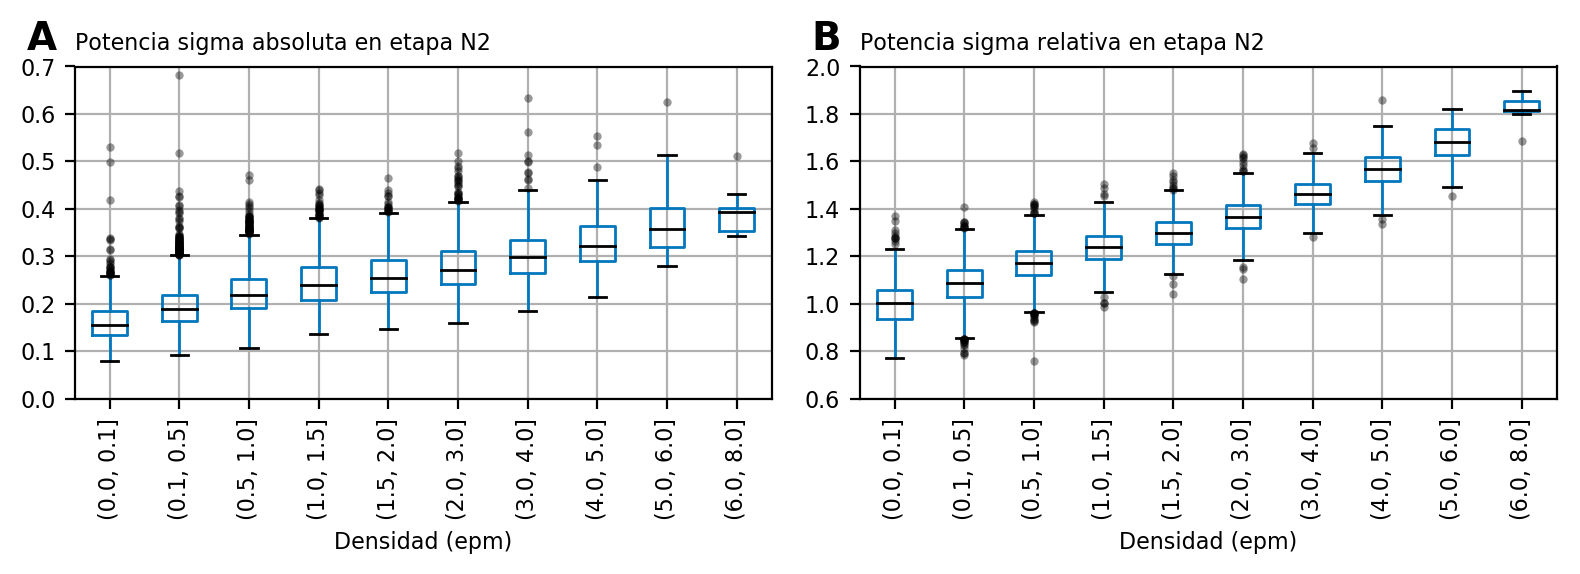

In [13]:
save_figure = True

density_thr_to_print = 0.1
n_below = np.sum(table_bysubject.density < density_thr_to_print)
n_total = len(table_bysubject)
print("There are %d subjects (%1.1f %%) with density less than %1.2f epm" % (n_below, 100 * n_below / n_total, density_thr_to_print))


df = table_bysubject.copy()
df['density_bin'] = pd.cut(table_bysubject.density, bins=[0, 0.1, 0.5, 1.0, 1.5, 2, 3, 4, 5, 6, 8])

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
df.boxplot(
    column=["n2_abs_sigma_power", "n2_rel_sigma_power"],
    by="density_bin", 
    ax=axes, fontsize=8, rot=90,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    boxprops=dict(color=viz.PALETTE['blue']),
    whiskerprops=dict(color=viz.PALETTE['blue']),
    medianprops=dict(color="k"),
)

fig.suptitle('')
for i_ax, ax in enumerate(axes):
    ax.set_title('')
    ax.set_xlabel("Densidad (epm)", fontsize=8)
    ax.text(
        x=-0.07, y=1.05, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
    
axes[0].set_title("Potencia sigma absoluta en etapa N2", fontsize=8, loc="left")
axes[0].set_ylim([0, 0.7])
axes[1].set_title("Potencia sigma relativa en etapa N2", fontsize=8, loc="left")
axes[1].set_ylim([0.6, 2.0])
    
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_density_power"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    
plt.show()

# Gráficos by-subject con suficientes detecciones

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


[ 476.   33.  284.   27.   19.   15.   17.  186.  206.  317.  439.  412.
  672. 1296. 1083.  624.  273.]
[534.  34. 292.  34.  21.  14.  26. 219. 265. 355. 519. 408. 394. 408.
 401. 418. 165.]


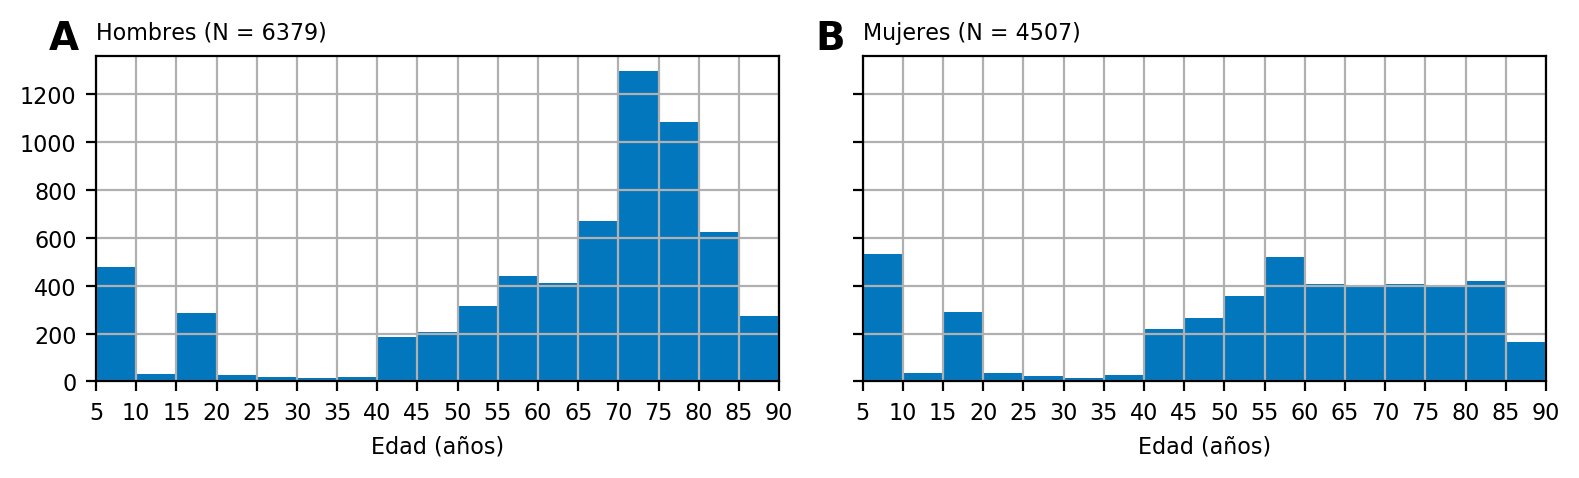

In [17]:
save_figure = True

# Demographics of subjects with enough detections
min_detections = 10
event_counts = np.round(table_bysubject["n2_minutes"] * table_bysubject["density"])
enough_dets = table_bysubject[event_counts >= min_detections]

# Those with less than 5 years are three subjects with 4.5, 4.9 and 4.9 y.o.. For statistics purposes those
# subjects will be within the bin containing 5 years old.
enough_dets["age"] = np.clip(enough_dets["age"], a_min=5, a_max=None)

ages_m = enough_dets[enough_dets.female == 0]["age"].values
ages_f = enough_dets[enough_dets.female == 1]["age"].values

bins = np.arange(5, 90 + 0.001, 5)
fig, axes = plt.subplots(1, 2, figsize=(8, 2.5), dpi=200, sharey=True)

ax = axes[0]
n, _, _ = ax.hist(ages_m, bins=bins, color=viz.PALETTE['blue'])
ax.set_title("Hombres (N = %d)" % len(ages_m), fontsize=8, loc="left")
print(n)

ax = axes[1]
n, _, _ = ax.hist(ages_f, bins=bins, color=viz.PALETTE['blue'])
ax.set_title("Mujeres (N = %d)" % len(ages_f), fontsize=8, loc="left")
print(n)

for i_ax, ax in enumerate(axes):
    ax.tick_params(labelsize=8)
    ax.set_xlabel("Edad (años)", fontsize=8)
    ax.set_xticks(bins)
    ax.grid()
    ax.set_xlim([bins[0], bins[-1]])
    ax.text(
        x=-0.07, y=1.02, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)

plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_composition"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)

plt.show()

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


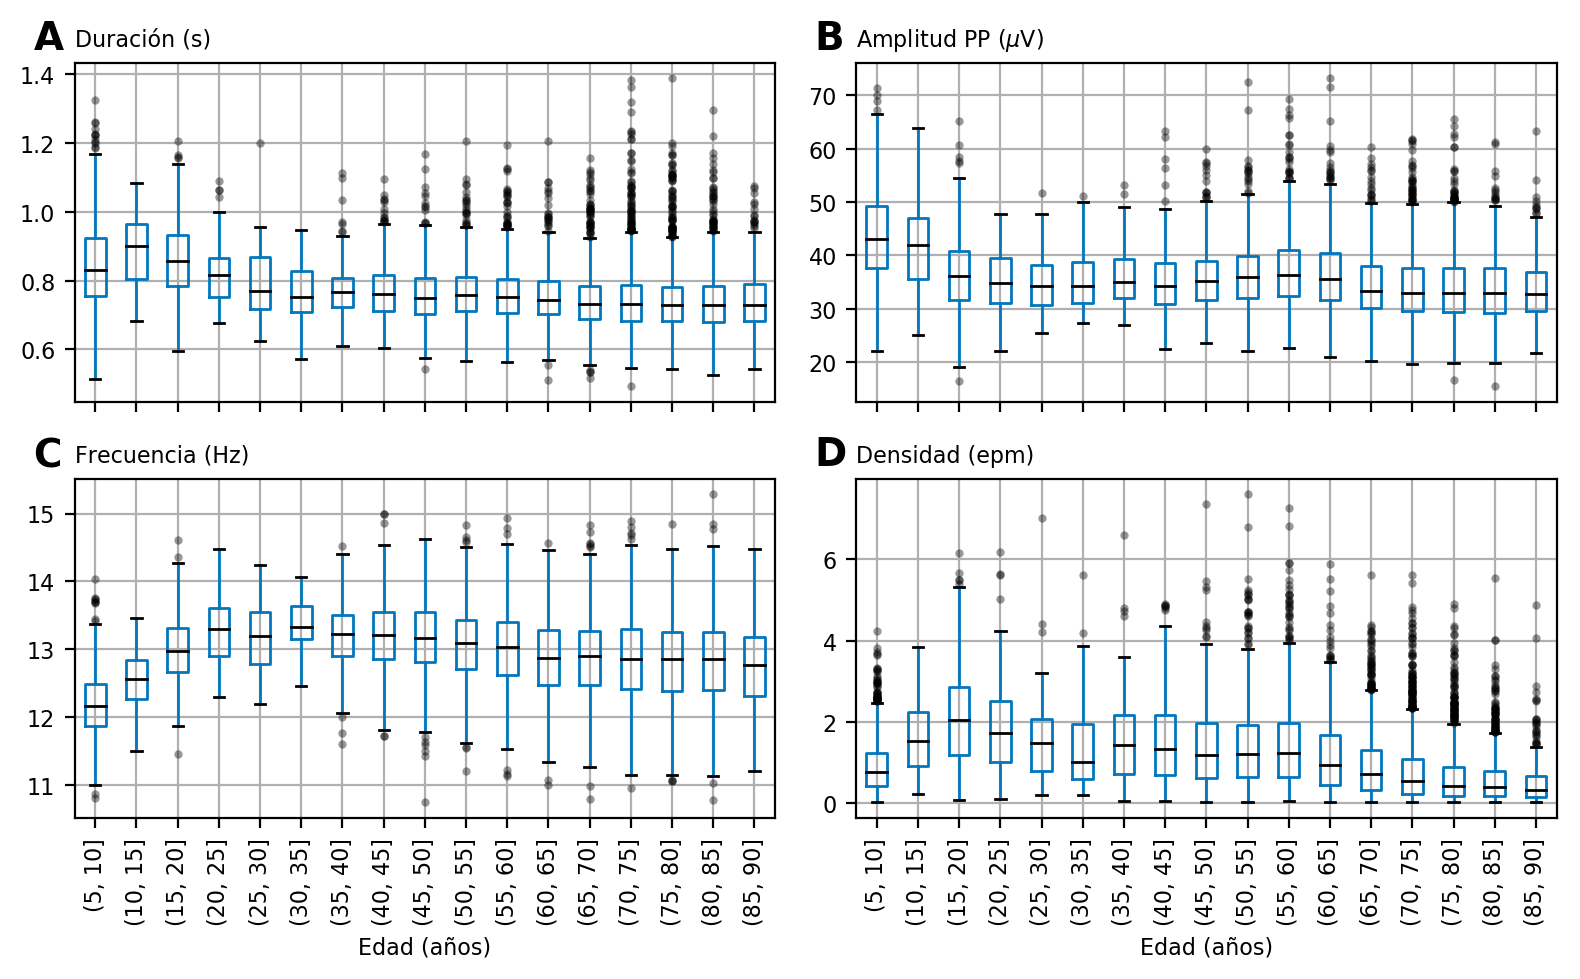

In [19]:
# by-subject params, age differences
save_figure = True

df = enough_dets.copy()
df['age_bin'] = pd.cut(enough_dets.age, bins=np.arange(5, 90 + 0.001, 5).astype(np.int32))

fig, axes = plt.subplots(2, 2, figsize=(8, 5), dpi=200, sharex=True)
df.boxplot(
    column=["duration", "amplitude", "frequency", "density"],
    by="age_bin", 
    ax=axes, fontsize=8, rot=90,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    boxprops=dict(color=viz.PALETTE['blue']),
    whiskerprops=dict(color=viz.PALETTE['blue']),
    medianprops=dict(color="k"),
)
fig.suptitle('')
for i_ax, ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=8)
    ax.set_title('')
    ax.set_xlabel('')
    ax.text(
        x=-0.06, y=1.04, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
axes[0, 0].set_title("Duración (s)", fontsize=8, loc="left")
axes[0, 1].set_title("Amplitud PP ($\mu$V)", fontsize=8, loc="left")
axes[1, 0].set_title("Frecuencia (Hz)", fontsize=8, loc="left")
axes[1, 1].set_title("Densidad (epm)", fontsize=8, loc="left")

axes[1, 0].set_xlabel("Edad (años)", fontsize=8)
axes[1, 1].set_xlabel("Edad (años)", fontsize=8)
    
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_age"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)

plt.show()

In [20]:
def barplot_annotate_brackets(ax, num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p <= 0.05
        # ** is p <= 0.01
        # *** is p <= 0.001
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = ax.get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh/2)

    ax.plot(barx, bary, c='black', linewidth=0.8)

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.annotate(text, mid, **kwargs)


Paramater duration, Age midpoint 8.5. female=0 with mean 0.8308 vs female=1 with mean 0.8626 (Diff -0.0318): P-value 0.0001
Paramater duration, Age midpoint 31.0. female=0 with mean 0.7934 vs female=1 with mean 0.8120 (Diff -0.0186): P-value 0.0002
Paramater duration, Age midpoint 70.0. female=0 with mean 0.7434 vs female=1 with mean 0.7592 (Diff -0.0158): P-value 0.0000

Paramater amplitude, Age midpoint 8.5. female=0 with mean 43.3175 vs female=1 with mean 44.1570 (Diff -0.8395): P-value 0.1433
Paramater amplitude, Age midpoint 31.0. female=0 with mean 34.5765 vs female=1 with mean 37.1474 (Diff -2.5709): P-value 0.0000
Paramater amplitude, Age midpoint 70.0. female=0 with mean 33.0804 vs female=1 with mean 37.7817 (Diff -4.7014): P-value 0.0000

Paramater frequency, Age midpoint 8.5. female=0 with mean 12.1331 vs female=1 with mean 12.2550 (Diff -0.1219): P-value 0.0001
Paramater frequency, Age midpoint 31.0. female=0 with mean 13.0314 vs female=1 with mean 13.1906 (Diff -0.1592): 

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


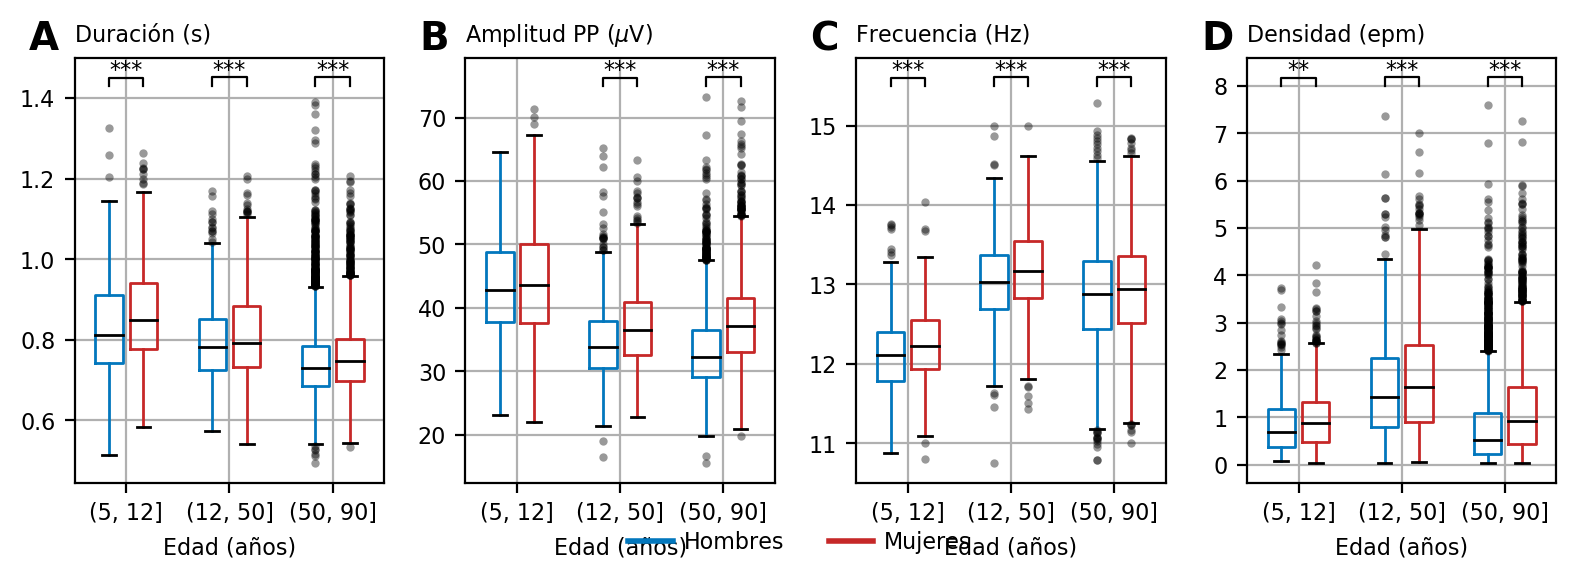

In [21]:
# by-subject params, sex differences
save_figure = True

df = enough_dets.copy()
df['age_bin'] = pd.cut(enough_dets.age, bins=[5, 12, 50, 90])

for param_name in ["duration", "amplitude", "frequency", "density"]:
    print("")
    for a in df.groupby(by="age_bin"):
        mid_age = a[0].mid
        data_l = []
        sex_l = []
        for b in a[1].groupby(by="female"):
            female = b[0]
            table = b[1]
            data_l.append(table[param_name].values)
            sex_l.append(female)
        # statistical test
        pvalue = stats.ttest_ind(data_l[0], data_l[1], equal_var=False)[1]
        print("Paramater %s, Age midpoint %1.1f. female=%d with mean %1.4f vs female=%d with mean %1.4f (Diff %1.4f): P-value %1.4f" % (
            param_name, mid_age,
            sex_l[0], data_l[0].mean(),
            sex_l[1], data_l[1].mean(),
            data_l[0].mean() - data_l[1].mean(),
            pvalue
        ))


fig, axes = plt.subplots(1, 4, figsize=(8, 3), dpi=200, sharex=True)
df[df.female==0].boxplot(
    column=["duration", "amplitude", "frequency", "density"],
    by=["age_bin"], 
    fontsize=8, rot=0, ax=axes,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    positions=[0.75, 2.25, 3.75], widths=0.4,
    boxprops=dict(color=viz.PALETTE['blue']),
    whiskerprops=dict(color=viz.PALETTE['blue']),
    medianprops=dict(color="k"),
)
df[df.female==1].boxplot(
    column=["duration", "amplitude", "frequency", "density"],
    by=["age_bin"], 
    fontsize=8, rot=0, ax=axes,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    positions=[1.25, 2.75, 4.25], widths=0.4, 
    boxprops=dict(color=viz.PALETTE['red']),
    whiskerprops=dict(color=viz.PALETTE['red']),
    medianprops=dict(color="k"),
)

fig.suptitle('')
for i_ax, ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=8)
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_xlim([0.25, 4.75])
    ax.set_xticks([1, 2.5, 4])
    ax.set_xlabel("Edad (años)", fontsize=8)
    ax.text(
        x=-0.15, y=1.02, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
axes[0].set_title("Duración (s)", fontsize=8, loc="left")
axes[1].set_title("Amplitud PP ($\mu$V)", fontsize=8, loc="left")
axes[2].set_title("Frecuencia (Hz)", fontsize=8, loc="left")
axes[3].set_title("Densidad (epm)", fontsize=8, loc="left")

# P-values
positions = np.array([0.75, 1.25, 2.25, 2.75, 3.75, 4.25])
param_dict = {
    'duration': dict(ax=axes[0], max_value=1.43),
    'amplitude': dict(ax=axes[1], max_value=75),
    'frequency': dict(ax=axes[2], max_value=15.5),
    'density': dict(ax=axes[3], max_value=8),
}
for param_name in param_dict.keys():
    plot_specs = param_dict[param_name]
    for i, a in enumerate(df.groupby(by="age_bin")):
        data_l = []
        for b in a[1].groupby(by="female"):
            data_l.append(b[1][param_name].values)
        pvalue = stats.ttest_ind(data_l[0], data_l[1], equal_var=False)[1]
        if pvalue <= 0.001:
            p_text = '***'
        elif pvalue <= 0.01:
            p_text = '**'
        elif pvalue <= 0.05:
            p_text = '*'
        else:
            p_text = 'ns'
            continue
        barplot_annotate_brackets(plot_specs['ax'], 2 * i, 2 * i + 1, p_text, positions, len(positions) * [plot_specs['max_value']], fs=8, dh=0.0, barh=0.02)

plt.tight_layout()
        
# Get legend
custom_lines = [Line2D([0], [0], color=viz.PALETTE['blue'], lw=2),
                Line2D([0], [0], color=viz.PALETTE['red'], lw=2)]
labels = ["Hombres", "Mujeres"]
lg1 = fig.legend(
    custom_lines, labels, fontsize=8, loc="lower center",
    bbox_to_anchor=(0.5, 0.02), ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_sex"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.3)

plt.show()

# Infra-slow oscillation

In [ ]:
# Measure clustering of detection on continuous segments of N2 pages
# Here I need the signals and predictions
